# Imports


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
mkdir /content/gdrive/MyDrive/vis

mkdir: cannot create directory ‘/content/gdrive/MyDrive/vis’: File exists


In [ ]:
!pip install -q -U tensorflow-hub tensorflow-text tensorflow-addons

In [ ]:
import os
import collections
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

Downloading Datasets

In [ ]:
root_dir="datasets"
annotations_dir=os.path.join(root_dir,"annotations")
images_dir=os.path.join(root_dir,"train2014")
tfrecords_dir =os.path.join(root_dir,"tfrecords")
annotation_file=os.path.join(annotations_dir,"captions_train2014.json")


#Download images file

if not os.path.exists(images_dir):
  images_zip=tf.keras.utils.get_file(
      "train2014.zip",
      cache_dir=os.path.abspath("."),
      origin="http://images.cocodataset.org/zips/train2014.zip",
      extract=True
                                 )
  os.remove(images_zip)


#Download captions
if not os.path.exists(annotations_dir):
  annotationszip=tf.keras.utils.get_file(
      "captions.zip",
       cache_dir=os.path.abspath("."),
       origin="http://images.cocodataset.org/annotations/annotations_trainval2014.zip",
       extract=True
                     )
  os.remove(annotationszip)

print("Datasets Downloaded Sucessfully")

with open(annotation_file, "r") as f:
  annotations=json.load(f)["annotations"]

image_path_to_caption= collections.defaultdict(list)
for element in annotations:
  caption=f"{element['caption'].lower().rstrip('.')}"
  image_path=images_dir+"/COCO_train2014_" + "%012d.jpg"%(element["image_id"])
  image_path_to_caption[image_path].append(caption)

image_paths=list(image_path_to_caption.keys())
print(f"Number of images: {len(image_paths)}")




13510574080/13510573713 [==============================] - 310s 0us/step
Datasets Downloaded Sucessfully
Number of images: 82783


In [ ]:
train_size=40000
valid_size=5000
captions_per_image=2
images_per_file=2000

train_image_paths=image_paths[:train_size]
num_train_files=int(np.ceil(train_size / images_per_file))
train_files_prefix = os.path.join(tfrecords_dir,"train")

valid_image_paths=image_paths[-valid_size:]
num_valid_files=int(np.ceil(valid_size / images_per_file))
valid_files_prefix = os.path.join(tfrecords_dir, "valid")

tf.io.gfile.makedirs(tfrecords_dir)


def bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def create_example(image_path,caption):
  feature ={
      "caption": bytes_feature(caption.encode()),
      "raw_image": bytes_feature(tf.io.read_file(image_path).numpy()),

  }

  return tf.train.Example(features=tf.train.Features(feature=feature))


def write_tfrecords(file_name,image_paths):
  caption_list=[]
  image_path_list=[]
  for image_path in image_paths:
    captions=image_path_to_caption[image_path][:captions_per_image]
    caption_list.extend(captions)
    image_path_list.extend([image_path]*len(captions))    

  with tf.io.TFRecordWriter(file_name) as writer:
    for example_idx in range(len(image_path_list)):
      example=create_example(
          image_path_list[example_idx],
          caption_list[example_idx] )  
      writer.write(example.SerializeToString())
  return example_idx +1         
  
def write_data(image_paths, num_files, files_prefix):
    example_counter = 0
    for file_idx in tqdm(range(num_files)):
        file_name = files_prefix + "-%02d.tfrecord" % (file_idx)
        start_idx = images_per_file * file_idx
        end_idx = start_idx + images_per_file
        example_counter += write_tfrecords(file_name, image_paths[start_idx:end_idx])
    return example_counter

train_example_count = write_data(train_image_paths, num_train_files, train_files_prefix)
print(f"{train_example_count} training examples were written to tfrecord files.")

valid_example_count = write_data(valid_image_paths, num_valid_files, valid_files_prefix)
print(f"{valid_example_count} evaluation examples were written to tfrecord files.")


  0%|          | 0/3 [00:00<?, ?it/s]

80000 training examples were written to tfrecord files.


100%|██████████| 3/3 [00:41<00:00, 13.69s/it]

10000 evaluation examples were written to tfrecord files.


In [ ]:
feature_description = {
    "caption":tf.io.FixedLenFeature([],tf.string),
    "raw_image":tf.io.FixedLenFeature([],tf.string),
}

def read_example(example):
    features = tf.io.parse_single_example(example,feature_description)
    raw_image =features.pop("raw_image")
    features["image"] =tf.image.resize(tf.image.decode_jpeg(raw_image,channels=3),size=(299,299))
    return features


def get_dataset(file_pattern,batch_size):

  return (tf.data.TFRecordDataset(tf.data.Dataset.list_files(file_pattern))
        .map(
            read_example,
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
            deterministic=False,
        )
        .shuffle(batch_size*10)
        .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        .batch(batch_size)
        )















In [ ]:
def project_embeddings(
    embeddings,num_projection_layers,projection_dims,dropout_rate
):
    projected_embeddings=layers.Dense(units=projection_dims)(embeddings)
    for i in range(num_projection_layers):
      x = tf.nn.gelu(projected_embeddings)
      x = layers.Dense(projection_dims)(x)
      x = layers.Dropout(dropout_rate)(x)
      x = layers.Add()([projected_embeddings,x])
      projected_embeddings = layers.LayerNormalization()(x)
    return projected_embeddings

In [ ]:
def create_vision_encoder(
    num_projection_layers,projection_dims, dropout_rate ,trainable=False
):

   xception=keras.applications.Xception(
       include_top=False, weights="imagenet",pooling="avg"
   )
   
   for layer in xception.layers:
     layer.trainable = trainable
      
   inputs =layers.Input(shape=(299,299,3), name="image_input")

   xception_input =tf.keras.applications.xception.preprocess_input(inputs)

   embeddings = xception(xception_input)

   outputs =project_embeddings(
        embeddings,num_projection_layers, projection_dims,dropout_rate
    )

   return keras.Model(inputs,outputs,name="vision_encoder")













In [ ]:
def create_text_encoder(
    num_projection_layers,projection_dims,dropout_rate,trainable=False
):
     preprocess=hub.KerasLayer(
         "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
         name="text_preprocessing",
     )

     bert = hub.KerasLayer(
         "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
         "bert",
     )

     bert.trainable =trainable

     inputs=layers.Input(shape=(),dtype=tf.string,name="text_input")

     bert_inputs =preprocess(inputs)

     embeddings =bert(bert_inputs)["pooled_output"]

     outputs =project_embeddings(
         embeddings,num_projection_layers,projection_dims,dropout_rate
         )
     
     return keras.Model(inputs,outputs,name="text_encoder")

     
  

In [ ]:
class DualEncoder(keras.Model):
   def __init__(self,text_encoder,image_encoder,temperature=1.0,**kwargs):
     super(DualEncoder,self).__init__(**kwargs)
     self.text_encoder=text_encoder
     self.image_encoder=image_encoder
     self.temperature =temperature
     self.loss_tracker=keras.metrics.Mean(name="loss")


   @property
   def metrics(self):
       return [self.loss_tracker]

   def call(self, features ,training=False):
       with tf.device("/gpu:0"):
         caption_embeddings=text_encoder(features["caption"],training = training)
       
       with tf.device("/gpu:0"):
         image_embeddings =vision_encoder(features["image"],training=training)
        
       return caption_embeddings,image_embeddings

   def compute_loss(self,caption_embeddings,image_embeddings):
        
        logits=(
            tf.matmul(caption_embeddings,image_embeddings,transpose_b=True)
        )

        images_similarity=tf.matmul(image_embeddings,image_embeddings,transpose_b=True
            
        )
        caption_similarity=tf.matmul(caption_embeddings,caption_embeddings,transpose_b=True)

        targets=keras.activations.softmax((caption_similarity+images_similarity)/(2*self.temperature))

        captions_loss= keras.losses.categorical_crossentropy(y_true=targets,y_pred=logits,from_logits=True)        
  
        images_loss=keras.losses.categorical_crossentropy(y_true=tf.transpose(targets),y_pred=tf.transpose(logits),from_logits=True)
         
        return (captions_loss+images_loss)/2

   def train_step(self,features):
       with tf.GradientTape() as tape:
         caption_embeddings,image_embeddings = self(features,training=True)
         loss=self.compute_loss(caption_embeddings,image_embeddings)
       
       gradients=tape.gradient(loss,self.trainable_variables)
       self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))

       self.loss_tracker.update_state(loss)

       return {"loss":self.loss_tracker.result()}

   def test_step(self,features):
        caption_embeddings,image_embeddings=self(features,training=False) 
        loss=self.compute_loss(caption_embeddings,image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss":self.loss_tracker.result()}



In [ ]:
num_epochs=14
batch_size=256

vision_encoder =create_vision_encoder(
    num_projection_layers=1,projection_dims=256,dropout_rate=0.1
)

text_encoder=create_text_encoder(
    num_projection_layers=1,projection_dims=256,dropout_rate=0.1
)

dual_encoder=DualEncoder(text_encoder,vision_encoder,temperature=0.05)

dual_encoder.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.008,weight_decay=0.001)
)

83689472/83683744 [==============================] - 0s 0us/step


In [ ]:
print(f"Number of GPUs:{len(tf.config.list_physical_devices('GPU'))}")
print(f"Number of examples (caption-image pairs):{train_example_count}")
print(f"Batch size:{batch_size}")
print(f"Steps per epoch:{int(np.ceil(train_example_count/batch_size))}")

train_dataset = get_dataset(os.path.join(tfrecords_dir,"train-*.tfrecord"),batch_size)
valid_dataset = get_dataset(os.path.join(tfrecords_dir,"valid-*.tfrecord"),batch_size)

reduce_lr=keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",factor=0.2,patience=3
)

early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",patience=5,restore_best_weights=True
)

history=dual_encoder.fit(train_dataset,
                         epochs=num_epochs,
                         validation_data=valid_dataset,
                         callbacks=[reduce_lr,early_stopping],
                         )

print("Training Completed.Saving vision and text encoders...")

vision_encoder.save("vision_encoder")
text_encoder.save("text_encoder")
print("models are saved")


Number of GPUs:1
Number of examples (caption-image pairs):80000
Batch size:256
Steps per epoch:313
Epoch 1/14
313/313 [==============================] - 1611s 5s/step - loss: 6.0138 - val_loss: 5.3356
Epoch 2/14
313/313 [==============================] - 1588s 5s/step - loss: 4.2459 - val_loss: 4.7084
Epoch 3/14
313/313 [==============================] - 1596s 5s/step - loss: 3.0900 - val_loss: 3.8823
Epoch 4/14
313/313 [==============================] - 1557s 5s/step - loss: 2.7397 - val_loss: 3.6749
Epoch 5/14
313/313 [==============================] - 1561s 5s/step - loss: 2.6056 - val_loss: 3.7301
Epoch 6/14
313/313 [==============================] - 1563s 5s/step - loss: 2.5168 - val_loss: 3.7737
Epoch 7/14
313/313 [==============================] - 1544s 5s/step - loss: 2.4506 - val_loss: 3.7461
Epoch 8/14
313/313 [==============================] - 1536s 5s/step - loss: 2.1070 - val_loss: 3.5905
Epoch 9/14
313/313 [==============================] - 1533s 5s/step - loss: 2.0825 - 

INFO:tensorflow:Assets written to: vision_encoder/assets


INFO:tensorflow:Assets written to: text_encoder/assets


INFO:tensorflow:Assets written to: text_encoder/assets


models are saved


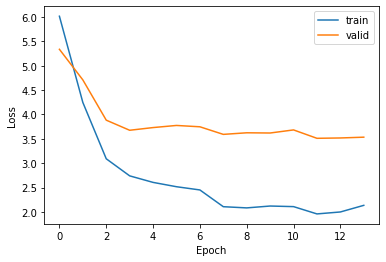

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [ ]:
cp -r vision_encoder /content/gdrive/MyDrive/Vision_encoder4

In [ ]:
cp -r text_encoder /content/gdrive/MyDrive/text_encoder4